In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content
DRIVE_PATH = '/content/gdrive/My\ Drive/DQN_GoL'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

SYM_PATH = '/content/DQN_GoL'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

%cd $SYM_PATH

/content
/content/gdrive/My Drive/DQN_GoL


In [3]:
import os
from google_drive_downloader import GoogleDriveDownloader as gdd

# install JAX DQN codebase requirements from requirements_colab.txt 
# %pip install -r requirements_colab.txt 
expt_dir = '/content/DQN_GoL/'
# 
os.chdir(expt_dir)
!pwd

required_files = [ 
                  'environment.py',
                  'our_buffer.py',
                  'our_utils.py'
                  ]
for f in required_files:
  assert os.path.isfile(f)


/content/gdrive/My Drive/DQN_GoL


In [4]:
# imports
import os.path as osp
import sys, time
import matplotlib.pyplot as plt
from matplotlib import rc
rc('animation', html='jshtml')
from functools import partial
import jax.numpy as jnp
from jax import random
from jax import jit, lax, grad, tree_map
from jax.experimental import stax
from jax.experimental.stax import GeneralConv, Flatten, Dense, Relu, LogSoftmax

import numpy as np
# import random

from environment import GameOfLifeEnv
from our_buffer import Buffer


%load_ext autoreload
%autoreload 2

# creating NN

In [29]:
### Convolutional Neural network
env = GameOfLifeEnv(grid_size=4, max_generations=250, density=0.4)


rng = random.PRNGKey(7656)
#

def create_q_net(env, rng):
  # conv net convention
  dim_nums=('NCHW', 'OIHW', 'NCHW') # default for (input, filters, output)

  # define functions which initialize the parameters and evaluate the model
  initialize_params, predict = stax.serial(    
                                              ### convolutional NN (CNN)
                                              GeneralConv(dim_nums, 25, (4,4), strides=(1,1) ), # 16 output channels, (4,4) filter
                                              Relu,
                                              # GeneralConv(dim_nums, 32, (3,3), strides=(1,1) ), # 32 output channels, (3,3) filter
                                              # Relu,
                                              Flatten, # flatten output
                                              # Dense(100),
                                              # Relu,
                                              Dense(16),
                                              Relu,
                                              Dense(env.grid_size ** 2), # 10 output neurons
                                              LogSoftmax # NB: computes the log-probability
                                          )

  # initialize the model parameters
  output_shape, inital_params = initialize_params(rng, (-1, 1, env.grid_size, env.grid_size)) # conv layer, 1 input channel, 28x28 pixes in each image

  return inital_params, predict

# inital_params, predict = create_q_net(env, rng)


# # print('\noutput shape of the model is {}.\n'.format(output_shape))
# states = []
# for i in np.arange(3):
#   states.append(env.reset().reshape(1, env.grid_size, env.grid_size))

# # check how network works on 3 examples
# predictions = predict(inital_params, np.array(states[0:3]))

# # # print shape of output
# # print("actual output shape is:", predictions.shape)

# # # check if probability is conserved
# print('prediction values:', predictions[0])
# print(states[0])
# print('prediction values:', predictions[1])
# print(states[1])
# print('prediction values:', predictions[2])
# print(states[2])

# creating Optimizer

In [30]:
from jax.experimental import optimizers # gradient descent optimizers

step_size = 0.001 # step size or learning rate 
momentum_mass = 0.9 # "gamma" parameter in GD+momentum


class Optimizer():
  def __init__(self, inital_params, step_size=0.001, momentum_mass=0.9):

    opt_init, self.opt_update, self.get_params = optimizers.momentum(step_size, mass=momentum_mass)
    self.opt_state = opt_init(inital_params)

    self.opt_step_count = gen_opt_step_count()


def gen_opt_step_count():
  i = 0
  while True:  
    yield i
    i +=1 



In [7]:
def huber_loss(x, delta: float = 1.0):
    """
    x: a vector of arbitrary shape.
    delta: the bounds for the huber loss transformation, defaults at 1.
    Note `grad(huber_loss(x))` is equivalent to `grad(0.5 * clip_gradient(x)**2)`.
    Returns:
    a vector of same shape of `x`.
    """
    abs_x = jnp.abs(x)
    quadratic = jnp.minimum(abs_x, delta)
    linear = abs_x - quadratic
    return 0.5 * quadratic ** 2 + delta * linear

def bellman_loss(Qnet_params, targets, actions, states):
    # for now we work only with a single trasition ... when implementing the buffer w'll revert bacj  to arrays and stuff
    predictions = predict(Qnet_params, states)
    # print(actions)
    # preds_select = predictions[0][actions]

    preds_select = jnp.take_along_axis(predictions, jnp.expand_dims(actions, axis=1), axis=1)

    return jnp.mean(huber_loss(preds_select - targets))

In [8]:
# @partial(jit, static_argnums=(0,))
def qlearning_step(NN_params,predict, gamma, rewards, next_states, dones):
    
    ### evaluate Q(s',a) for all actions
    next_Q_values = predict(NN_params, next_states)

    ### Bellman update
    # (1-is_terminal) sets Q-value of terminal states to zero
    Q_values = rewards + gamma * jnp.max(next_Q_values, axis=1) * (1-dones)


    ### do not push gradients thru Q_values
    Q_values = lax.stop_gradient(Q_values)

    return Q_values

In [9]:
def take_epsilon_greedy_action(predictions, eps):
    n = len(predictions)
    p = np.random.uniform()
    if (p < eps):
        a = np.random.choice(n)
    else: 
        m = np.amax(predictions)
        all_argmax_positions = [i for i, j in enumerate(predictions) if j == m]
#         print(f'Taking a greedy action. There are {len(all_argmax_positions)} actions with max value')
        a = np.random.choice(all_argmax_positions)
    return a 


# testinf buffer

In [291]:
env = GameOfLifeEnv(grid_size=4, seed=42, max_generations=25, density=0.4)
buffer = Buffer(1000)
i = 0
while i < 100:
  state = env.reset()
  done = False
  while not done:
    # step
    a = np.random.choice(env.grid_size**2) #take_random_action(state)
    next_state, r, done = env.step(a)
    # add to buffer
    # print(state)
    buffer.add(state, a, r, next_state, done)
    state = next_state
    i += 1
    if i >= 100:
      done = True
      break

# print(buffer.states)
# print(buffer.dones)
# for i in range(10):
#   print(i, buffer.rewards[i],  buffer.actions[i], buffer.dones[i], buffer.states[i])

b = buffer.sample(20)
# print(b.round(2))

# definition of the algorithme insidea train func

In [10]:
def num_to_array_of_bin(num, grid_size):
  n = grid_size**2
  s = np.array([int(x) for x in bin(int(num))[2:]])
  return np.append(s[::-1], np.zeros((n - len(s)))).reshape(1, grid_size, grid_size)

def get_states_from_ids(ids, grid_size):
  return np.array([num_to_array_of_bin(id, grid_size) for id in ids])




In [254]:
def train(env, NN_params, optimizer, buffer, N_batches=100, batch_size=32, eps=0.1, gamma=1):

  for i in range(N_batches):

    batch = buffer.sample(batch_size)
    states = get_states_from_ids(batch[0, :], env.grid_size)

    predictions = predict(NN_params, states)
    actions = batch[1, :]
    rewards = batch[2, :]
    next_states = get_states_from_ids(batch[3, :], env.grid_size)
    dones = batch[4, :]

    # calculate y_i
    Q_values = qlearning_step(NN_params, gamma, rewards, next_states, dones)

    # calculate and clip grad
    gradients = grad(bellman_loss)(NN_params, Q_values[:, None], actions, states)
    clipped_gradients = tree_map(lambda g: jnp.clip(g, -10.0, 10.0), gradients)

    # optimizer stuff
    new_opt_state = optimizer.opt_update(next(optimizer.opt_step_count), clipped_gradients, optimizer.opt_state)

    NN_params = optimizer.get_params(new_opt_state)
    optimizer.opt_state = new_opt_state

  return NN_params

In [11]:
def add_to_buffer(buffer, N, env, predict,NN_params=None,  eps=0.1):
  i = 0

  while i < N:
    state = env.reset()
    done = False
    while not done:
      if NN_params:
        predictions = predict(NN_params, state.reshape(1, 1, env.grid_size, env.grid_size))
        a = take_epsilon_greedy_action(predictions[0], eps)
      else:
        a = np.random.choice(env.grid_size**2)

      next_state, r, done = env.step(a)

      buffer.add(state, a, r, next_state, done)
      state = next_state
      i += 1
      if i >= N:
        done = True
        break


# training and plotting

prefiling buffer done
0


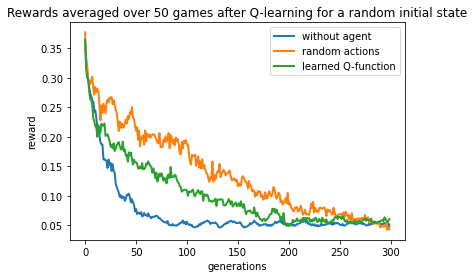

10
20
30
40
50
60


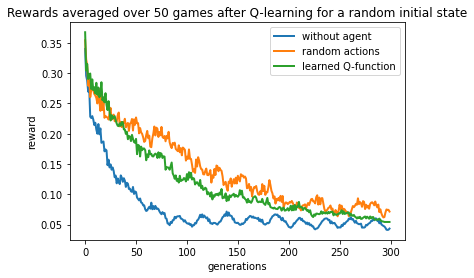

70
80
90
100
110
120


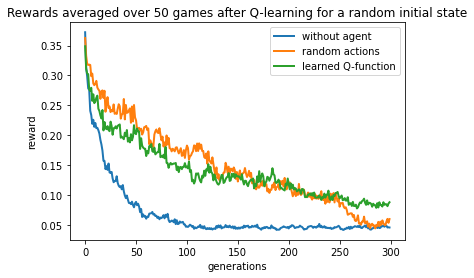

130
140
150
160
170
180


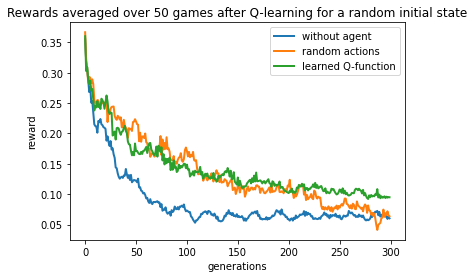

190
200
210
220
230
240


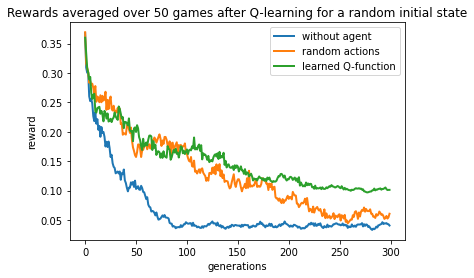

250
260
270
280
290
300


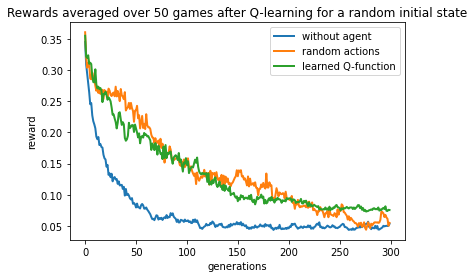

310
320
330
340
350
360


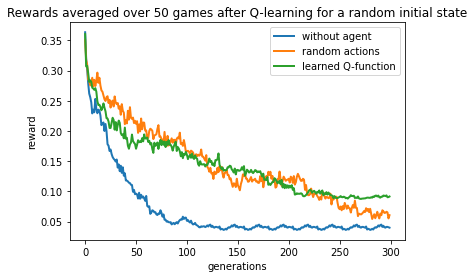

370
380
390
400
410


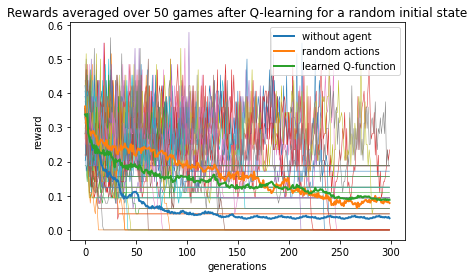

420


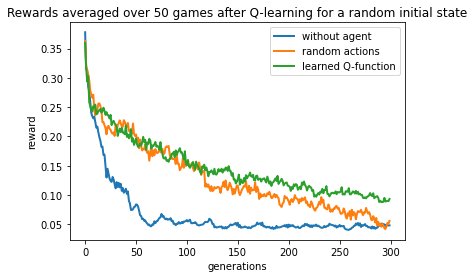

In [46]:
%matplotlib inline
%matplotlib inline

env = GameOfLifeEnv(grid_size=8, max_generations=300, density=0.4)

rng1 = random.PRNGKey(75)
rng2 = random.PRNGKey(56)

Q_net_params, predict = create_q_net(env, rng1)
Q_net_target_params, target_predict = create_q_net(env, rng2)

optimizer = Optimizer(Q_net_params)

buffer = Buffer(5000)
add_to_buffer(buffer, 2000, env,predict, Q_net_params, 0.1)
print('prefiling buffer done')

N_train = 421
batch_size = 32
gamma = 1
target_update = 10
plot_freq = 60
add_to_buffer_freq = 5
eps = np.linspace(0.5, 0.1, N_train)
# print(eps)

for i in range(N_train):
  if i % add_to_buffer_freq == 0:
    add_to_buffer(buffer, 120, env, predict, Q_net_params, eps[i])

  batch = buffer.sample(batch_size)
  states = get_states_from_ids(batch[0, :], env.grid_size)

  predictions = predict(Q_net_params, states)
  actions = batch[1, :]
  rewards = batch[2, :]
  next_states = get_states_from_ids(batch[3, :], env.grid_size)
  dones = batch[4, :]

  # calculate y_i
  Q_values = qlearning_step(Q_net_target_params, target_predict, gamma, rewards, next_states, dones)

  # calculate and clip grad
  gradients = grad(bellman_loss)(Q_net_params, Q_values[:, None], actions, states)
  clipped_gradients = tree_map(lambda g: jnp.clip(g, -10.0, 10.0), gradients)

  # optimizer stuff
  new_opt_state = optimizer.opt_update(next(optimizer.opt_step_count), clipped_gradients, optimizer.opt_state)

  Q_net_params = optimizer.get_params(new_opt_state)
  optimizer.opt_state = new_opt_state

  if i % target_update == 0:
    print(i)
    Q_net_target_params = optimizer.get_params(new_opt_state)

  if i % plot_freq == 0:
    plot_after_avg(env, Q_net_params, trained_for=i, max_gen_to_plot=300)

  if i == N_train - 3:
    plot_after_avg(env, Q_net_params, trained_for=i, max_gen_to_plot=300, show_all = True)

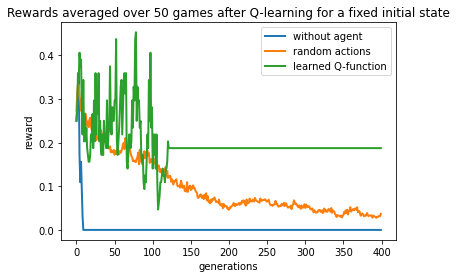

In [44]:
plot_after_avg(env, Q_net_params, trained_for=600, max_gen_to_plot=400)

In [34]:
# %matplotlib inline
# %matplotlib inline


# env = GameOfLifeEnv(grid_size=4, max_generations=250, density=0.4)
# N_batches = 50
# buffer = Buffer(1000)
# add_to_buffer(buffer, 500, env)

# optimizer = Optimizer(inital_params)

# # ######################## train for 100 and plot #########################################
# trained_for = 0
# NN_params = train(env, inital_params, optimizer, buffer, N_batches, eps=0.5, gamma=1)
# trained_for += N_batches
# plot_after_avg(env, NN_params, trained_for=trained_for, max_gen_to_plot=50)
# add_to_buffer(buffer, 100, env, NN_params)

# ####################### train for 100 more and plot again #########################################
# NN_params = train(env, NN_params, optimizer, buffer, N_batches=70, eps=0.2, gamma=1)
# trained_for += N_batches
# plot_after_avg(env, NN_params,  trained_for=trained_for, max_gen_to_plot=50)
# add_to_buffer(buffer, 100, env, NN_params)

# # ######################## train for 100 more and plot again #########################################
# # NN_params, opt_state = train(env, NN_params, opt_state, buffer, N_batches=2000, eps=0.15, gamma=1)
# # trained_for += N_batches
# # plot_after_avg(env, NN_params, trained_for=trained_for, max_gen_to_plot=50)
# # add_to_buffer(buffer, 500, env, NN_params)
# ######################## train for 100 more and plot again #########################################
# # NN_params, opt_state = train(env, NN_params, opt_state, buffer, N_batches=1000, eps=0.12, gamma=1)
# # trained_for += N_batches
# # plot_after_avg(env, NN_params, trained_for=trained_for, max_gen_to_plot=50)
# # add_to_buffer(buffer, 500, env, NN_params)
# # ######################## train for 100 more and plot again #########################################
# # NN_params, opt_state = train(env, NN_params, opt_state, buffer, N_batches=1000, eps=0.1, gamma=1)
# # trained_for += N_batches
# # plot_after_avg(env, NN_params, trained_for=trained_for, max_gen_to_plot=50)
# # add_to_buffer(buffer, 500, env, NN_params)
# # ######################## train for 100 more and plot again #########################################
# # NN_params, opt_state = train(env, NN_params, opt_state, buffer, N_batches=1000, eps=0.11, gamma=1)
# # trained_for += N_batches
# # plot_after_avg(env, NN_params, trained_for=trained_for, max_gen_to_plot=50)
# # add_to_buffer(buffer, 500, env, NN_params)
# # ######################## train for 100 more and plot again #########################################
# # NN_params, opt_state = train(env, NN_params, opt_state, buffer, N_batches=1000, eps=0.1, gamma=1)
# # trained_for += N_batches
# # plot_after_avg(env, NN_params, trained_for=trained_for, max_gen_to_plot=50)
# # add_to_buffer(buffer, 500, env, NN_params)
# ############################################
# ###################animation################
# ############################################
# %matplotlib notebook
# %matplotlib notebook


# env = GameOfLifeEnv(grid_size=4, max_generations=50, density=0.4, save_states=True)
# state = env.reset()
# done = False

# while not done:
#     state = state.reshape(1, 1, env.grid_size, env.grid_size)
#     predictions = predict(NN_params, state)
#     a = take_epsilon_greedy_action(predictions[0], 0)
#     state, r, done = env.step(a)

# env.render()


In [38]:
%matplotlib notebook
%matplotlib notebook

env = GameOfLifeEnv(grid_size=8, seed=39, max_generations=400, density=0.4, save_states=True)
state = env.reset()
done = False

while not done:
    state = state.copy().reshape(1, 1, env.grid_size, env.grid_size)
    predictions = predict(Q_net_params, state)
    a = take_epsilon_greedy_action(predictions[0], 0)
    state, r, done = env.step(a)

env.render()

Output hidden; open in https://colab.research.google.com to view.

In [45]:
%matplotlib inline

def plot_after_avg(env, NN_params, trained_for, max_gen_to_plot=250, show_all=False):
    eps = 0
    fig, ax = plt.subplots()
    # ax.set_ylim([0, 0.45])

    all_rewards_Q = np.zeros(max_gen_to_plot)
    all_rewards_no_action = np.zeros_like(all_rewards_Q)
    all_rewards_r = np.zeros_like(all_rewards_Q)
    # final_rs = np.zeros(N_games)
    # actions from the Q function
    N_games = 50
    for i in range(N_games):
        state = env.reset()
        rewards_Q = np.zeros(max_gen_to_plot)
        done = False
        for j in range(len(rewards_Q)):
            if not done:
                state = state.reshape(1, 1, env.grid_size, env.grid_size)
                predictions = predict(NN_params, state)
                a = take_epsilon_greedy_action(predictions[0], 0)
                state, r, done = env.step(a)
                rewards_Q[j] = r
            
        # final_rs[i] = rewards_Q[max_gen_to_plot-2]
        if show_all: 
          ax.plot(rewards_Q[:max_gen_to_plot], linewidth=0.5)
        #
        all_rewards_Q = all_rewards_Q + rewards_Q
    avg_Q = all_rewards_Q / N_games

    # base evolution
    N_games = 50
    for i in range(N_games):
        env.reset()
        rewards_no_action = np.zeros(max_gen_to_plot)
        done = False
        for j in range(len(rewards_no_action)):
            if not done:
                _, r, done = env.step(None)
                rewards_no_action[j] = r

        all_rewards_no_action = all_rewards_no_action + rewards_no_action
    avg_no_action = all_rewards_no_action / N_games

    # taking random actions
    N_games = 50
    for i in range(N_games):
        state = env.reset()
        rewards_r = np.zeros(max_gen_to_plot)
        done = False
        for j in range(len(rewards_r)):
            if not done:
                a = np.random.choice(env.grid_size**2) #take_random_action(state)
                _, r, done = env.step(a)
                rewards_r[j] = r
        all_rewards_r = all_rewards_r + rewards_r
    avg_random = all_rewards_r / N_games

    ax.set_title(f'Rewards averaged over {N_games} games after Q-learning for a random initial state')
    ax.plot(avg_no_action[:max_gen_to_plot], linewidth = 2, label='without agent')
    ax.plot(avg_random[:max_gen_to_plot], linewidth = 2, label='random actions')
    ax.plot(avg_Q[:max_gen_to_plot], linewidth = 2, label='learned Q-function')

    plt.legend()
    ax.set_xlabel('generations')
    ax.set_ylabel('reward')
    name = f'./FINAL_noseed{trained_for}_games_grid{env.grid_size}_DQN7'
    plt.savefig(name, transparent=True, bbox_inches='tight')
    plt.show()


[0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]


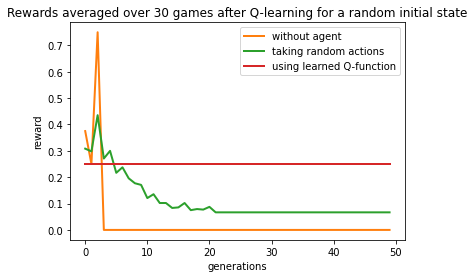

In [169]:
# trained_for += N_games
plot_after_avg(env, NN_params, trained_for=trained_for, max_gen_to_plot=50)

In [170]:
# %matplotlib notebook
# %matplotlib notebook


# from matplotlib import rc
# rc('animation', html='jshtml')

# env = GameOfLifeEnv(grid_size=4, seed=42, max_generations=50, density=0.4, save_states=True)

# state = env.reset()
# state = state.reshape(1, 1, env.grid_size, env.grid_size)

# done = False
# a = take_epsilon_greedy_action(predictions[0], 0)

# while not done:
#     predictions = predict(NN_params, state)
#     print(predictions.copy())
#     print(state)
#     a = take_epsilon_greedy_action(predictions[0], 0)
#     state, r, done = env.step(a)
#     print(r)
#     state = state.reshape(1, 1, env.grid_size, env.grid_size)


# env.render()


[[-3.2702534 -3.2606714 -3.4850097 -3.4082532 -3.343234  -3.3764248
  -3.241423  -3.2140477 -3.3488228 -3.299752  -3.2479897 -3.270618
  -0.7730823 -3.3754666 -3.2791846 -3.5476558]]
[[[[1. 0. 0. 0.]
   [1. 1. 1. 0.]
   [0. 0. 1. 0.]
   [0. 1. 1. 1.]]]]
0.25
[[-3.2702534 -3.2606714 -3.4850097 -3.4082532 -3.343234  -3.3764248
  -3.241423  -3.2140477 -3.3488228 -3.299752  -3.2479897 -3.270618
  -0.7730823 -3.3754666 -3.2791846 -3.5476558]]
[[[[0. 0. 0. 0.]
   [1. 0. 1. 0.]
   [0. 0. 0. 0.]
   [1. 0. 1. 0.]]]]
0.0


<IPython.core.display.Javascript object>

In [ ]:
a = np.zeros((3,4,2))
a[:, None]

array([[[[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]]])

In [ ]:
a

array([[[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]]])

In [ ]:
state = env.reset()
state = state.reshape(1, 1, env.grid_size, env.grid_size)
# state
np.array([state])

array([[[[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]]]]])